In [1]:
%load_ext autoreload
%autoreload 2

#import standard libs
from IPython.display import display
#from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 100)

from dask import dataframe as dd
from dask.diagnostics import ProgressBar

pbar = ProgressBar()
pbar.register()

import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
#import pymc3 as pm
#from theano import shared, theano as tt

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno



In [2]:
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 12,8
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# get project dir
pp = PurePath(Path.cwd()).parts[:-2]
print(pp)
pdir = PurePath(*pp)
script_dir = pdir / 'src' 
viz_dir = pdir / 'report' / 'figures'
data_dir = pdir / 'data'
script_dirs = list(Path(script_dir).glob('./*/'))
for sdir in script_dirs: sys.path.append(sdir.as_posix())

# import python scientific stack

RANDOM_STATE = 777

from utils import *
from bars import *

('/', 'home', 'ale', 'py-projects', 'Adv_Fin_ML_Exercises')


In [3]:
infp=PurePath(data_dir/'interim'/'IVE_tickbidask.parq')
df = pd.read_parquet(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2018-10-19 15:59:59  111.96  111.95  111.96    900    900   100764.00
2018-10-19 16:00:00  111.97  111.95  111.96  12439  12439  1392794.83
2018-10-19 16:10:00  111.97  111.31  112.10      0      0        0.00
2018-10-19 18:30:00  111.97  110.70  112.40      0      0        0.00
2018-10-19 20:00:00  111.97  110.81  112.40      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1431009 entries, 2009-09-28 09:30:00 to 2018-10-19 20:00:00
Data columns (total 6 columns):
price    1431009 non-null float64
bid      1431009 non-null float64
ask      1431009 non-null float64
size     1431009 non-null int6

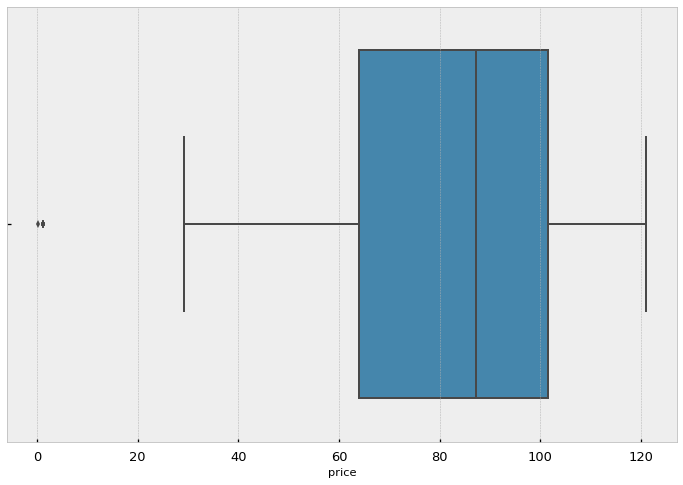

In [4]:
sns.boxplot(df.price)

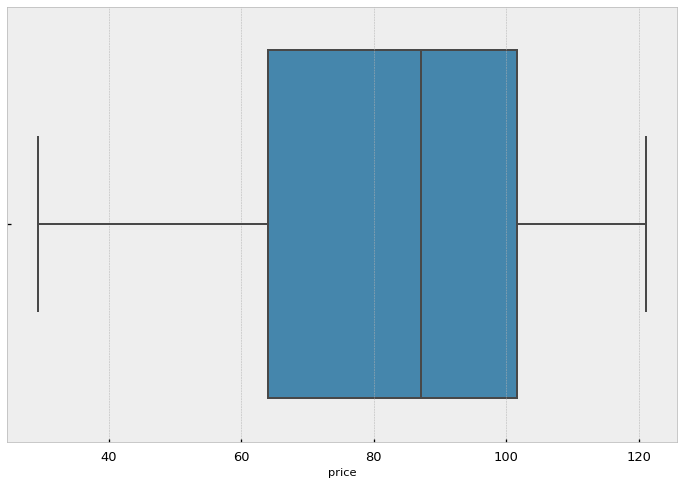

In [5]:
mad = mad_outlier(df.price.values.reshape(-1,1))
df = df.loc[~mad]
sns.boxplot(df.price)

In [6]:
dollar_M = 1_000_000 # arbitrary 
#print(f'dollar threshold: {dollar_M:,}')
dv_bar_df = dollar_bar_df(df, 'dv', dollar_M)
cprint(dv_bar_df)

100%|██████████| 1430998/1430998 [00:00<00:00, 2645869.26it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2018-10-19 15:57:50  112.09  112.08  112.09   1500   1500   168135.00
2018-10-19 15:59:07  112.01  112.00  112.01    306    306    34275.06
2018-10-19 15:59:37  111.96  111.96  111.97    313    313    35043.48
2018-10-19 15:59:58  111.97  111.96  111.98   1586   1586   177584.42
2018-10-19 16:00:00  111.97  111.95  111.96  12439  12439  1392794.83
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51439 entries, 2009-09-28 09:46:35 to 2018-10-19 16:00:00
Data columns (total 6 columns):
price    51439 non-null float64
bid      51439 non-null float64
ask      51439 non-null float64
size     51439 non-null int64
v       

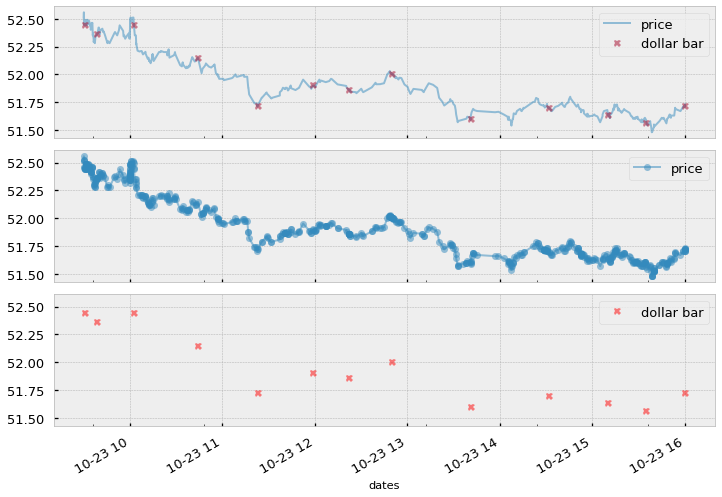

In [7]:
xDate ='2009-10-23' #'2017-10-4'
xdf, xtdf = select_sample_data(df, dv_bar_df, 'price', xDate)

plot_sample_data(xdf, xtdf, 'dollar bar', alpha=0.5, markersize=7)

In [9]:
tick_M = 200 # arbitrary
tick_df = tick_bar_df(df, 'price', tick_M)

100%|██████████| 1430998/1430998 [00:00<00:00, 2750099.83it/s]


In [10]:
tick_ret = returns(tick_df.price)
dv_ret = returns(dv_bar_df.price)
dv_ret.autocorr()


-0.12273212558154578

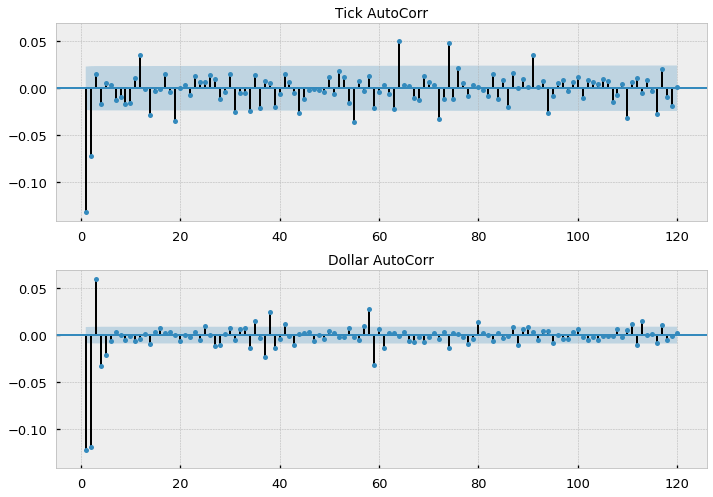

In [11]:
plot_autocorr(bar_types=['Tick', 'Dollar'], bar_returns=[tick_ret, dv_ret])

In [12]:
bar_types= ['Tick', 'Dollar'] 
bar_returns = [tick_ret, dv_ret]

get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

,sample_size,jb_stat
Tick,7153.0,1.127301e+08
Dollar,51438.0,5.559126e+10


In [13]:
get_test_stats(bar_types,bar_returns,shapiro).sort_values('shapiro_stat')[::-1]

,sample_size,shapiro_stat
Tick,7153.0,0.592870
Dollar,51438.0,0.407535
